In [1]:
import csv
import pandas as pd
import numpy as np
from sentence_transformers import CrossEncoder
import matplotlib.pyplot as plt
from IPython.display import FileLink

CSV_PROP = "proposicoes-detalhes.csv"
CSV_AUT  = "proposicoes-autores.csv"

QUERY = "sistema prisional"
TOP_N = 20  # para visualizar detalhadamente os mais relevantes

# Mapeamento de partido -> eixo ideológico
PARTY_AXIS = {
    "PT": "Esquerda",
    "PCdoB": "Esquerda",
    "PSOL": "Esquerda",
    "PSTU": "Esquerda",
    "PCB": "Esquerda",
    "UP": "Esquerda",
    "PCO": "Esquerda",
    "PDT": "Centro-esquerda",
    "PSB": "Centro-esquerda",
    "CIDADANIA": "Centro-esquerda",
    "PV": "Centro-esquerda",
    "REDE": "Centro-esquerda",
    "MDB": "Centro",
    "PSD": "Centro",
    "PSDB": "Centro",
    "AVANTE": "Centro",
    "SOLIDARIEDADE": "Centro",
    "PMB": "Centro",
    "PP": "Centro-direita",
    "AGIR": "Centro-direita",
    "PMN": "Centro-direita",
    "MOBILIZA": "Centro-direita",
    "UNIÃO": "Centro-direita",
    "PRD": "Centro-direita",
    "PRTB": "Direita",
    "REPUBLICANOS": "Direita",
    "PL": "Direita",
    "NOVO": "Direita",
    "DC": "Direita",
    "PODE": "Direita",
}


/home/lasagna/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
csv.field_size_limit(10**7)

df_prop = pd.read_csv(
    CSV_PROP,
    sep=";",
    engine="python",
    quoting=csv.QUOTE_ALL,
    encoding="utf-8",
)

df_prop["id"] = df_prop["id"].astype(int)

df_autores = pd.read_csv(
    CSV_AUT,
    sep=";",
    engine="python",
    quoting=csv.QUOTE_ALL,
    encoding="utf-8",
)

df_autores["id_proposicao"] = df_autores["id_proposicao"].astype(int)
df_autores["id_autor"] = df_autores["id_autor"].astype(int)

print("Proposições em df_prop:", df_prop["id"].nunique())
print("Proposições em df_autores:", df_autores["id_proposicao"].nunique())
df_prop.head(), df_autores.head()


Proposições em df_prop: 5311
Proposições em df_autores: 4989


(        id siglaTipo  numero   ano   descricaoTipo  \
 0  2481874        PL       1  2025  Projeto de Lei   
 1  2481875        PL       2  2025  Projeto de Lei   
 2  2482075        PL       5  2025  Projeto de Lei   
 3  2482076        PL       6  2025  Projeto de Lei   
 4  2482079        PL       7  2025  Projeto de Lei   
 
                                               ementa  \
 0  Dispõe sobre a criação de oito varas federais ...   
 1  Dispõe sobre a reestruturação de cargos da mag...   
 2  Proíbe a utilização de recursos públicos para ...   
 3  Dispõe sobre a inclusão de disposições no Códi...   
 4  Altera a Lei nº 8.078 de 11 de setembro de 199...   
 
                                      ementaDetalhada  \
 0                                                NaN   
 1                                                NaN   
 2                                                NaN   
 3  Altera o Decreto-Lei nº 3.689, de 3 de Outubro...   
 4                                     

In [3]:
df_autores["eixo_ideologico"] = (
    df_autores["siglaPartido"]
    .map(PARTY_AXIS)
    .fillna("Sem classificação")
)

df_autores[["id_proposicao", "nome_autor", "siglaPartido", "siglaUf", "eixo_ideologico"]].head()


,id_proposicao,nome_autor,siglaPartido,siglaUf,eixo_ideologico
0,2482075,Marcelo Álvaro Antônio,PL,MG,Direita
1,2482076,Marcelo Álvaro Antônio,PL,MG,Direita
2,2482079,Duarte Jr.,PSB,MA,Centro-esquerda
3,2482081,Duarte Jr.,PSB,MA,Centro-esquerda
4,2482081,Duda Ramos,MDB,RR,Centro


In [4]:
# Texto usado para ranqueamento: ementa + ementaDetalhada (quando houver)
textos_prop = (
    df_prop["ementa"].fillna("")
    + " "
    + df_prop.get("ementaDetalhada", "").fillna("")
)

pairs = [(QUERY, txt) for txt in textos_prop.tolist()]
len(pairs)


5311

In [5]:
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
scores = reranker.predict(pairs)
scores = np.array(scores)

df_scores = pd.DataFrame({
    "id": df_prop["id"].values,
    "score_sistema_prisional": scores,
})

df_scores.head()


,id,score_sistema_prisional
0,2481874,-11.394751
1,2481875,-11.369564
2,2482075,-11.269305
3,2482076,-11.334322
4,2482079,-11.349602


In [6]:
df_rank = df_scores.merge(
    df_prop,
    on="id",
    how="left",
)

print(len(df_rank))
df_rank.head()


5311


,id,score_sistema_prisional,siglaTipo,numero,ano,descricaoTipo,ementa,ementaDetalhada,keywords,dataApresentacao,...,status_sequencia,status_siglaOrgao,status_regime,status_descricaoTramitacao,status_codTipoTramitacao,status_descricaoSituacao,status_codSituacao,status_despacho,status_ambito,status_apreciacao
0,2481874,-11.394751,PL,1,2025,Projeto de Lei,Dispõe sobre a criação de oito varas federais ...,NaN,"Criação, vara federal, Tribunal Regional Feder...",2025-01-02T17:58,...,46,MESA,"Urgência (Art. 155, RICD)",Transformação em Norma Jurídica,251,Transformado em Norma Jurídica,1140.0,Transformado na Lei Ordinária 15172/2025. DOU ...,Regimental,Proposição Sujeita à Apreciação do Plenário
1,2481875,-11.369564,PL,2,2025,Projeto de Lei,Dispõe sobre a reestruturação de cargos da mag...,NaN,"Cargo vago, Juiz substituto, transformação, ju...",2025-01-02T18:10,...,49,MESA,"Urgência (Art. 155, RICD)",Apresentação de Proposição,100,Transformado em Norma Jurídica,1140.0,Recebido Ofício nº 684/2025-SF que comunica re...,Regimental,Proposição Sujeita à Apreciação do Plenário
2,2482075,-11.269305,PL,5,2025,Projeto de Lei,Proíbe a utilização de recursos públicos para ...,NaN,"Alteração, Lei Paulo Gustavo (2022), Lei Rouan...",2025-02-02T13:01,...,21,CASP,"Ordinário (Art. 151, III, RICD)",Notificacao para Publicação Intermediária,1050,Tramitando em Conjunto,925.0,"Designado Relator, Dep. Ronaldo Nogueira (REPU...",Regimental,Proposição Sujeita à Apreciação Conclusiva pel...
3,2482076,-11.334322,PL,6,2025,Projeto de Lei,Dispõe sobre a inclusão de disposições no Códi...,"Altera o Decreto-Lei nº 3.689, de 3 de Outubro...","Alteração, Código de Processo Penal (1941), Có...",2025-02-02T13:01,...,14,CCJC,"Prioridade (Art. 151, II, RICD)",Recebimento,500,Tramitando em Conjunto,925.0,Recebimento pela CCJC.,Regimental,Proposição Sujeita à Apreciação do Plenário
4,2482079,-11.349602,PL,7,2025,Projeto de Lei,Altera a Lei nº 8.078 de 11 de setembro de 199...,NaN,"Alteração, Código de Defesa do Consumidor (199...",2025-02-02T21:50,...,17,CDC,"Ordinário (Art. 151, III, RICD)",Notificacao para Publicação Intermediária,1050,Tramitando em Conjunto,925.0,"Designado Relator, Dep. Felipe Carreras (PSB-P...",Regimental,Proposição Sujeita à Apreciação do Plenário


In [7]:
autores_agregados = (
    df_autores
    .assign(
        autor_fmt=lambda d: (
            d["nome_autor"]
            + " ("
            + d["siglaPartido"].fillna("")
            + "/"
            + d["siglaUf"].fillna("")
            + ", "
            + d["eixo_ideologico"]
            + ")"
        )
    )
    .groupby("id_proposicao")
    .agg(
        autores=("autor_fmt", lambda xs: "; ".join(sorted(set(xs)))),
        eixos_presentes=("eixo_ideologico", lambda xs: "; ".join(sorted(set(xs))))
    )
    .reset_index()
    .rename(columns={"id_proposicao": "id"})
)

autores_agregados.head()


,id,autores,eixos_presentes
0,2482075,"Marcelo Álvaro Antônio (PL/MG, Direita)",Direita
1,2482076,"Marcelo Álvaro Antônio (PL/MG, Direita)",Direita
2,2482079,"Duarte Jr. (PSB/MA, Centro-esquerda)",Centro-esquerda
3,2482081,"Duarte Jr. (PSB/MA, Centro-esquerda); Duda Ram...",Centro; Centro-esquerda
4,2482103,"Bibo Nunes (PL/RS, Direita); Delegado Paulo Bi...",Centro; Centro-direita; Direita


In [8]:
df_rank_agregado = df_rank.merge(
    autores_agregados,
    on="id",
    how="left",
)

cols_mostrar = [
    "id",
    "score_sistema_prisional",
    "siglaTipo",
    "numero",
    "ano",
    "ementa",
    "autores",
    "eixos_presentes",
]

topN_agregado = (
    df_rank_agregado
    .sort_values("score_sistema_prisional", ascending=False)
    [cols_mostrar]
    .head(TOP_N)
)

pd.set_option("display.max_colwidth", 160)
topN_agregado

# Salva rankings em CSV
topN_agregado.to_csv("topN_sistema_prisional_ementa.csv", index=False, encoding="utf-8-sig")
df_rank_agregado.to_csv("todos_projetos_sistema_prisional_ementa.csv", index=False, encoding="utf-8-sig")

FileLink("topN_sistema_prisional_ementa.csv")


/home/lasagna/cebrap-lab-ia-r-python/tutorial/topN_sistema_prisional_ementa.csv

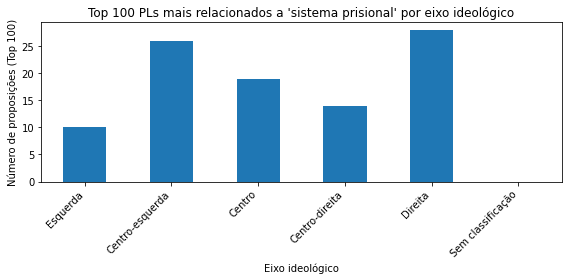

In [9]:
# Seleciona top 100 projetos mais relacionados a "sistema prisional"
top100 = (
    df_rank_agregado
    .sort_values("score_sistema_prisional", ascending=False)
    .head(100)
    .copy()
)

# Explode dos eixos ideológicos (campo "eixos_presentes" separado por ";")
eixos = (
    top100[["id", "eixos_presentes"]]
    .dropna(subset=["eixos_presentes"])
    .assign(eixo=lambda d: d["eixos_presentes"].str.split(";"))
    .explode("eixo")
)

eixos["eixo"] = eixos["eixo"].str.strip()
eixos = eixos[eixos["eixo"] != ""]
eixos = eixos.drop_duplicates(subset=["id", "eixo"])

ordem_eixos = [
    "Esquerda",
    "Centro-esquerda",
    "Centro",
    "Centro-direita",
    "Direita",
    "Sem classificação",
]

counts = eixos["eixo"].value_counts()
counts = counts.reindex(ordem_eixos, fill_value=0)

plt.figure(figsize=(8, 4))
counts.plot(kind="bar")
plt.xlabel("Eixo ideológico")
plt.ylabel("Número de proposições (Top 100)")
plt.title("Top 100 PLs mais relacionados a 'sistema prisional' por eixo ideológico")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
